グリッドサーチでのチューニング

In [3]:
from pm3.wdbc import WDBC

wdbc = WDBC()
X_train, y_train = wdbc.train_datasets()
X_test, y_test = wdbc.test_datasets()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy', cv=10, refit=True, n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)

print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


最高評価のモデルを取得して、テストしてみる

In [4]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


入子式の交差検証

In [5]:
import numpy as np
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


決定木の深さパラメータのチューニング

In [6]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


混同行列による評価

[[71  1]
 [ 2 40]]


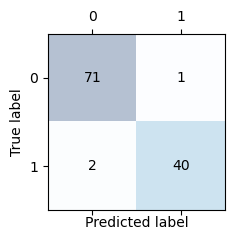

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_mat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.get_cmap('Blues'), alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

適合率、再現率、F1スコアを出力

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


カスタムの性能指標を出力

In [11]:
from sklearn.metrics import make_scorer

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__kernel': ['rbf'], 'svc__gamma': c_gamma_range}]

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


ROC曲線をプロットする
面白くするために、特徴量を減らして、交差検証の分割数も減らす

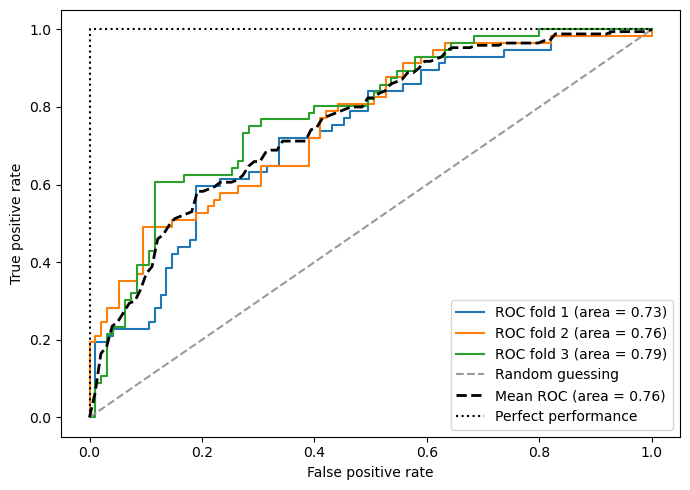

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=1, C=100.0))

X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i + 1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

クラスの不均衡に対処

不均衡なデータを作ってみる

In [13]:
X_imb = np.vstack((X_train[y_train == 0], X_train[y_train == 1][:40]))
y_imb = np.hstack((y_train[y_train == 0], y_train[y_train == 1][:40]))

y_pred = np.zeros(y_imb.shape[0])

np.mean(y_pred == y_imb)

0.8769230769230769

復元抽出をしてみる

In [18]:
from sklearn.utils import resample

print('Number of class 1 example before:', X_imb[y_imb == 1].shape[0])

X_up_sampled, y_up_sampled = resample(X_imb[y_imb == 1],
                                      y_imb[y_imb == 1],
                                      replace=True,
                                      n_samples=X_imb[y_imb == 0].shape[0],
                                      random_state=123)
print('Number of class 1 example before:', X_up_sampled[y_up_sampled == 1].shape[0])

X_bal = np.vstack((X_train[y_train == 0], X_up_sampled))
y_bal = np.hstack((y_train[y_train == 0], y_up_sampled))

y_pred = np.zeros(y_bal.shape[0])

np.mean(y_pred == y_bal)

Number of class 1 example before: 40
Number of class 1 example before: 285


0.5